In [472]:
import torch
from torch import nn
import os
import glob as glob
from torch.utils.data import DataLoader, Dataset, Subset
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
from tqdm import tqdm
from multiprocessing import Process
from IPython.display import clear_output, display
from time import sleep

In [505]:
model_file = 'data_file.csv'
coder_file = 'coder.txt'

In [506]:
class DataLoader:
    def __init__(self, model_file, coder_file):
        self.model_file = model_file
        with open(coder_file, 'r') as f:
            self.labels = f.readlines()
        for l in range(len(self.labels)):
            self.labels[l] = self.labels[l][:-1]
        self.soln = file.split('/')[6]
        self.data = {}

    def data_process(self):
        df = pd.read_csv(self.model_file)
        self.data = [] # some magic
        self.len = len(self.data)


In [507]:
dataset = DataLoader(model_file, coder_file)

In [508]:
dataset.data_process()

In [509]:
feature_list = []

In [510]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(35, 1024),
            nn.ReLU(),
            nn.Linear(1024, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 21), #41
            #nn.Softmax(dim=1))
            nn.Sigmoid())
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [511]:
path = './model_MkIV.pth'
model = NeuralNetwork()
model.load_state_dict(torch.load(path))
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=35, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=21, bias=True)
    (7): Sigmoid()
  )
)

In [512]:
i = np.random.randint(dataset.len)

data_string = []
for feature in feature_list:
    for j in range(5):
        data_string.append(dataset.data[feature][j][i])

with torch.no_grad():

    outputs = model(torch.from_numpy(np.array([data_string])).float())

    lo = list(outputs[0])
    st = dataset.labels[lo.index(max(lo[0:2]))]
    lo = lo[2:]
    bs = dataset.labels[lo.index(max(lo[0:2]))+2]
    lo = lo[2:]
    p_soln = dataset.labels[lo.index(max(lo))+4]
    
    print(f'Prediction: {st}, {bs}, {p_soln}')

Prediction: Stable, Solution, Hot Shot Confidence Check


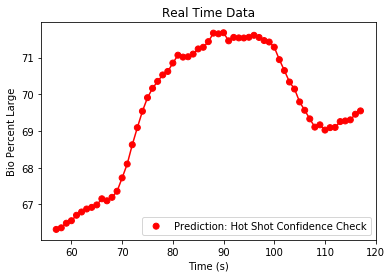

KeyboardInterrupt: 

In [514]:
%matplotlib inline
t = []
color = []
bpct_l = []
soln_counter = 0
alarm = False
for i in range(dataset.len):
    clear_output(wait=True)
    t.append(i)

    data_string = []
    for feature in feature_list:
        for j in range(5):
            data_string.append(dataset.data[feature][j][i])

    with torch.no_grad():

        outputs = model(torch.from_numpy(np.array([data_string])).float())

        lo = list(outputs[0])
        st = dataset.labels[lo.index(max(lo[0:2]))]
        lo = lo[2:]
        bs = dataset.labels[lo.index(max(lo[0:2]))+2]
        lo = lo[2:]
        p_soln = dataset.labels[lo.index(max(lo))+4]
        
        if p_soln == 'Background':
            color.append('green')
            soln_counter = 0
            alarm = False
        else:
            soln_counter += 1
            if soln_counter == 10:
                color.append('red')
                alarm = True
                alarm_time = i
            elif soln_counter > 10:
                    color.append('red')
            else:
                color.append('green')
        bpct_l.append(dataset.data['bpct_l'][1][i]*100)
        
        if i < 60:
            plt.scatter(t[:i+1], bpct_l[:i+1],label =f'Prediction: {p_soln}',c=color)
            plt.plot(t[:i+1], bpct_l[:i+1],c=color[-1])
        else:
            plt.scatter(t[i-60:i+1], bpct_l[i-60:i+1],label =f'Prediction: {p_soln}',c=color[i-60:i+60])
            plt.plot(t[i-60:i+1], bpct_l[i-60:i+1],c=color[-1])
        if alarm and alarm_time > (i+1-60):
            plt.axvline(alarm_time,color='red')
            
        plt.xlabel('Time (s)')
        plt.ylabel('Bio Percent Large')
        plt.title('Real Time Data')
        plt.legend()
        plt.show()

        sleep(1)

# 